This is a combination of the track_latent_space.ipynb and cameo_data_s0.ipynb in an attempt to be organized.

In [9]:
import os
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from scipy.spatial import distance
import py3Dmol
from DSSPparser import parseDSSP

LATENTSPACE_UNPERTURBED = "../data/taccruns/predictions-latentspacesave1-unperturbed/"#"../data/taccruns/predictions-latentspace-unperturbed/"

CAMEO_PREDICTION_PATH_model1 = "../data/taccruns/predictions-cameo-model1ptm/"
CAMEO_PREDICTION_PATH_model4 = "../data/taccruns/predictions-cameo-model4ptm/"
CAMEO_PREDICTION_PATH_model1_ZEROED_SINGLE_REP = "../data/taccruns/predictions-cameo-mod-s0-model1ptm/"
CAMEO_PREDICTION_PATH_model4_ZEROED_SINGLE_REP = "../data/taccruns/predictions-cameo-mod-s0-model4ptm/"
CAMEO_PREDICTION_PATH_model1_1ITER = "../data/taccruns/predictions-cameo-model1ptm-numiter_1/"
CAMEO_PREDICTION_PATH_model1_1ITER_ZEROED_SINGLE_REP = "../data/taccruns/predictions-cameo-mod-s0-model1ptm-numiter_1/"
CAMEO_PREDICTION_PATH_model1_fulliter_struct_module_s0_only_first_block = "../data/taccruns/predictions-cameo-model1ptm-fulliter-struct_module_s0_only_first_block/"
CAMEO_PREDICTION_PATH_model1_1iter_struct_module_s0_only_first_block = "../data/taccruns/predictions-cameo-model1ptm-1iter-struct_module_s0_only_first_block/"
CAMEO_PREDICTION_PATH_model1_fulliter_s0_after_struc_modu = "../data/taccruns/predictions-cameo-model1ptm-fulliter-s0_after_struc_modu/"

CAMEO_GNDTRUTH = '../data/taccruns/cameo_gnd_truth/'
DSSP_PATH = "../data/taccruns/DSSP/"
FASTA_DIR = "../data/taccruns/fasta_dir/"

In [5]:
# check all proteins are present in each file are exactly the same
# no failed runs

In [ ]:
def tmscore_vs_gndtruth(target,modified):
    '''
    "    -infmt1  Input format for chain1\n"
"    -infmt2  Input format for chain2\n"
"            -1: (default) automatically detect PDB or PDBx/mmCIF format\n"
"             0: PDB format\n"
"             1: SPICKER format\n"
"             2: xyz format\n"
"             3: PDBx/mmCIF format\n"
    '''
    pass

In [48]:
def tmscore(target, modified):
    tmscore = -1
    os.system(f"./../tmscore/TMscore {target} {modified} >> tmscore_temp_output")
    with open("tmscore_temp_output") as f:
        for line in f:
            if line.startswith("TM-score"):
                tmscore = float(line.split('=')[1].strip().split(' ')[0])
    os.system("rm tmscore_temp_output")
    return tmscore

cameo_dict = {}
for pdb_file in os.listdir(CAMEO_PREDICTION_PATH_model1): #for each predicted structure
    if pdb_file[-1] == "b": #check if is a pdb file
        if pdb_file[19:26] == 'unrelax': #check if it the unrelaxed prediction
            protein = pdb_file[0:6]
            cameo_dict[protein] = {}
            cameo_dict[protein]['tmscore_model1'] = tmscore(CAMEO_PREDICTION_PATH_model1 + pdb_file, CAMEO_PREDICTION_PATH_model1_ZEROED_SINGLE_REP + pdb_file)
            cameo_dict[protein]['tmscore_model4'] = tmscore(CAMEO_PREDICTION_PATH_model4 + pdb_file[0:6]+"_model_4_ptm_unrelaxed.pdb", CAMEO_PREDICTION_PATH_model4_ZEROED_SINGLE_REP + pdb_file[0:6]+"_model_4_ptm_unrelaxed.pdb")
            cameo_dict[protein]['tmscore_model1_1iter'] = tmscore(CAMEO_PREDICTION_PATH_model1_1ITER + pdb_file, CAMEO_PREDICTION_PATH_model1_1ITER_ZEROED_SINGLE_REP + pdb_file)
            cameo_dict[protein]['tmscore_model1_struc_modu_s0firstblock_1iter'] = tmscore(CAMEO_PREDICTION_PATH_model1_1ITER + pdb_file, CAMEO_PREDICTION_PATH_model1_1iter_struct_module_s0_only_first_block + pdb_file)
            cameo_dict[protein]['tmscore_model1_struc_modu_s0firstblock'] = tmscore(CAMEO_PREDICTION_PATH_model1 + pdb_file, CAMEO_PREDICTION_PATH_model1_fulliter_struct_module_s0_only_first_block + pdb_file)
            cameo_dict[protein]['tmscore_model1_s0_after_struc_modu'] = tmscore(CAMEO_PREDICTION_PATH_model1 + pdb_file, CAMEO_PREDICTION_PATH_model1_fulliter_s0_after_struc_modu + pdb_file)
            cameo_dict[protein]['avg_tmscore'] = (cameo_dict[protein]['tmscore_model1'] + \
                cameo_dict[protein]['tmscore_model4'] + \
                    cameo_dict[protein]['tmscore_model1_1iter'] + \
                        cameo_dict[protein]['tmscore_model1_struc_modu_s0firstblock_1iter'] + \
                            cameo_dict[protein]['tmscore_model1_struc_modu_s0firstblock'] + \
                                cameo_dict[protein]['tmscore_model1_s0_after_struc_modu']) / 6
stats = list(cameo_dict['6tf4_A'].keys())

In [59]:
lst_iterations = [f"i{i}" for r in range(4) for i in range(8)]
lst_iterations[0] = "r0 i0"
lst_iterations[8] = "r1 i0"
lst_iterations[16] = "r2 i0"
lst_iterations[24] = "r3 i0"
cos = nn.CosineSimilarity(dim=0)
plt.rcParams['figure.figsize'] = [17, 7]
def latent_space_cosine_AND_tmscore_barchart(protein):
    fig, axes = plt.subplots(1, 2)
    rep='s'
    data = np.empty([32,32]) 
    for r1 in range(4):
        for i1 in range(8):
            for r2 in range(4):
                for i2 in range(8):
                    file_1 = LATENTSPACE_UNPERTURBED + protein + '_lspace' + '/' + rep + '_iter_' + str(i1) + '_recy_' + str(r1) + '_.pt'
                    file_2 = LATENTSPACE_UNPERTURBED + protein + '_lspace' + '/' + rep + '_iter_' + str(i2) + '_recy_' + str(r2) + '_.pt'
                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*8)+i1, (r2*8)+i2] = cos(t1,t2)
    sns.heatmap(data, xticklabels = lst_iterations, yticklabels = lst_iterations, annot=False, ax=axes[0]).set(title=f'Structure module s latent space\n cosine similarity | unperturbed run')
    #sns.invert_yaxis()
    #ax.set_title(protein + f' | latent space: {rep} | unperturbed\n' + 'recycle (r) structure module iteration (i)' )
    # barplot
    tmscore_stats = []
    for stat in stats:
        tmscore_stats.append(cameo_dict[protein][stat])
    wrapped_labels = [ label.replace('_', '\n') for label in stats ]
    sns.barplot(x=wrapped_labels,y=tmscore_stats, ax=axes[1]).set(title='tmscore(unperturbed, purterbed with s=s*0)')
    fig.suptitle(f'{protein}')
    plt.show()

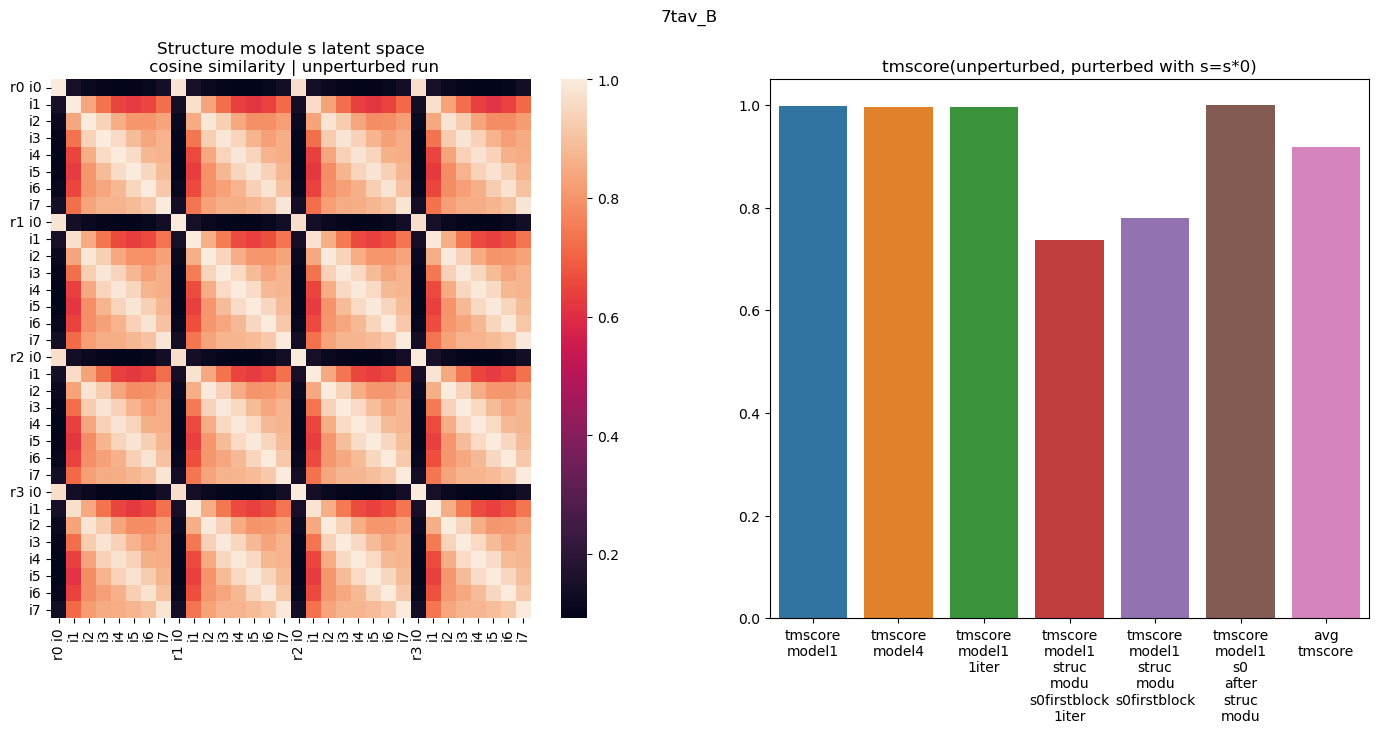

In [60]:
latent_space_cosine_AND_tmscore_barchart('7tav_B')

In [61]:
# sort by tmscore avg then plot
unsorted_protein_dict = {}
for protein in cameo_dict.keys():
    unsorted_protein_dict[protein] = cameo_dict[protein]['avg_tmscore']
sorted_portein_list = []
for w in sorted(unsorted_protein_dict, key=unsorted_protein_dict.get, reverse=False):
    sorted_portein_list.append(w)



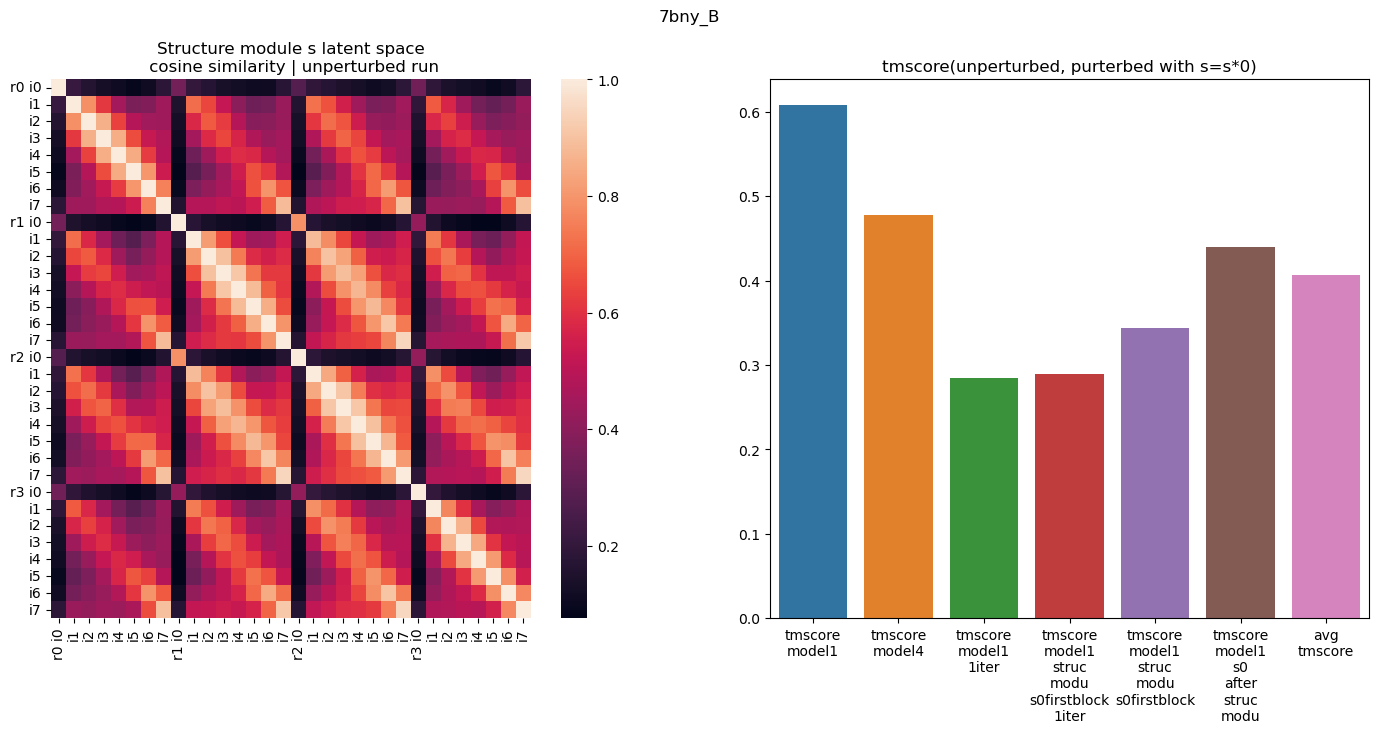

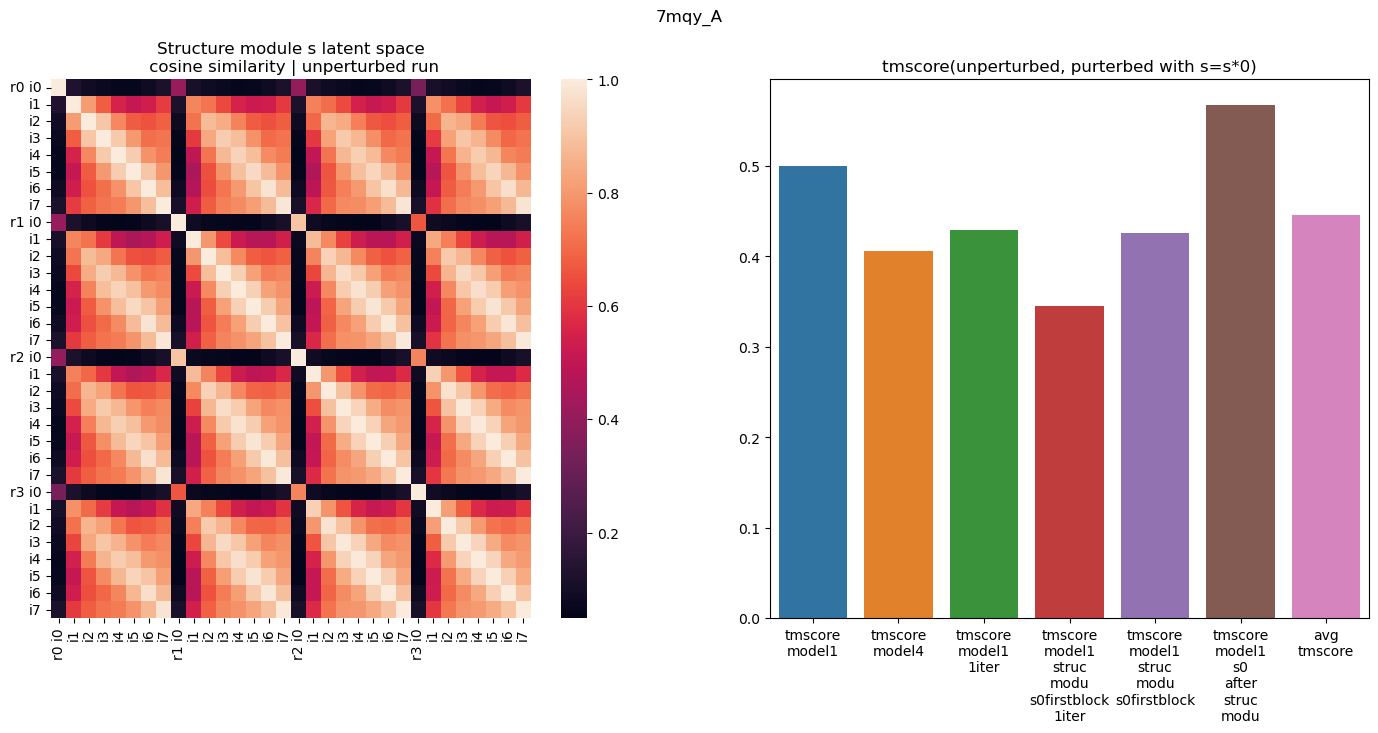

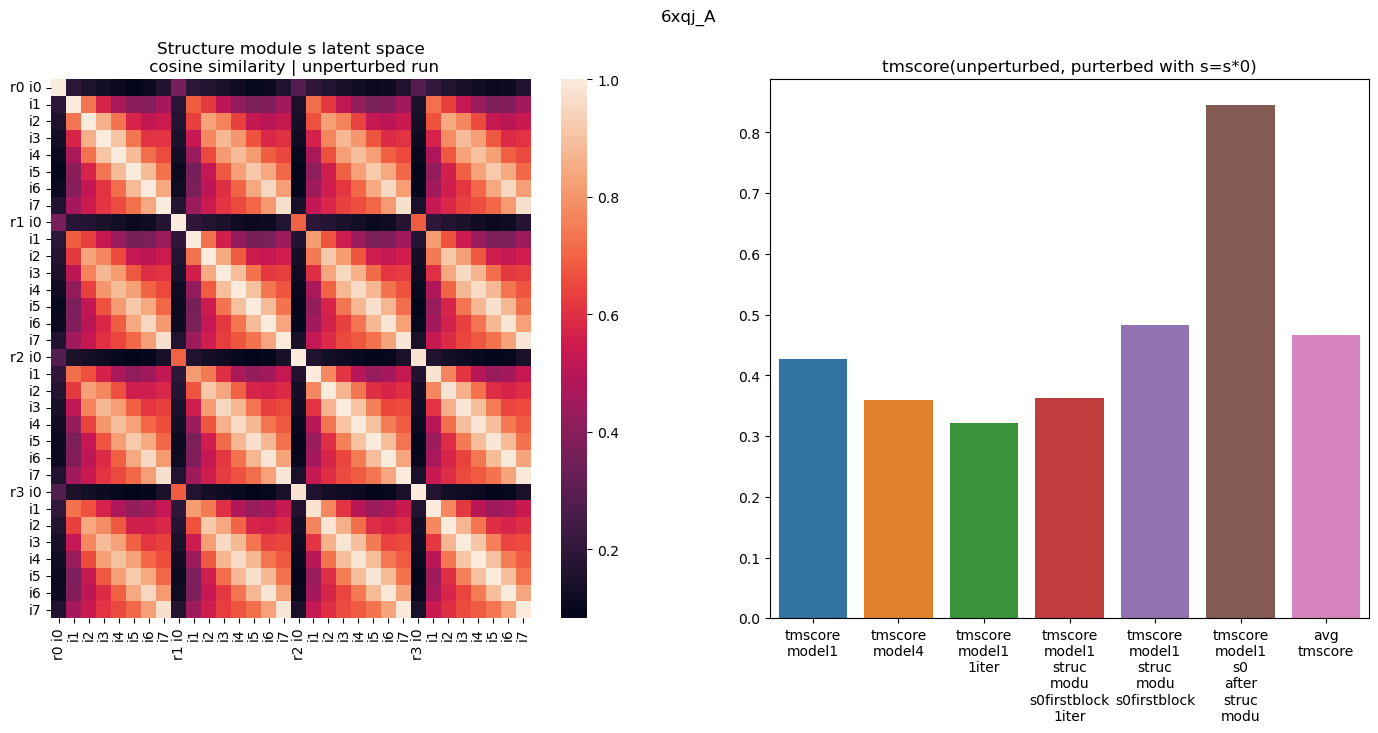

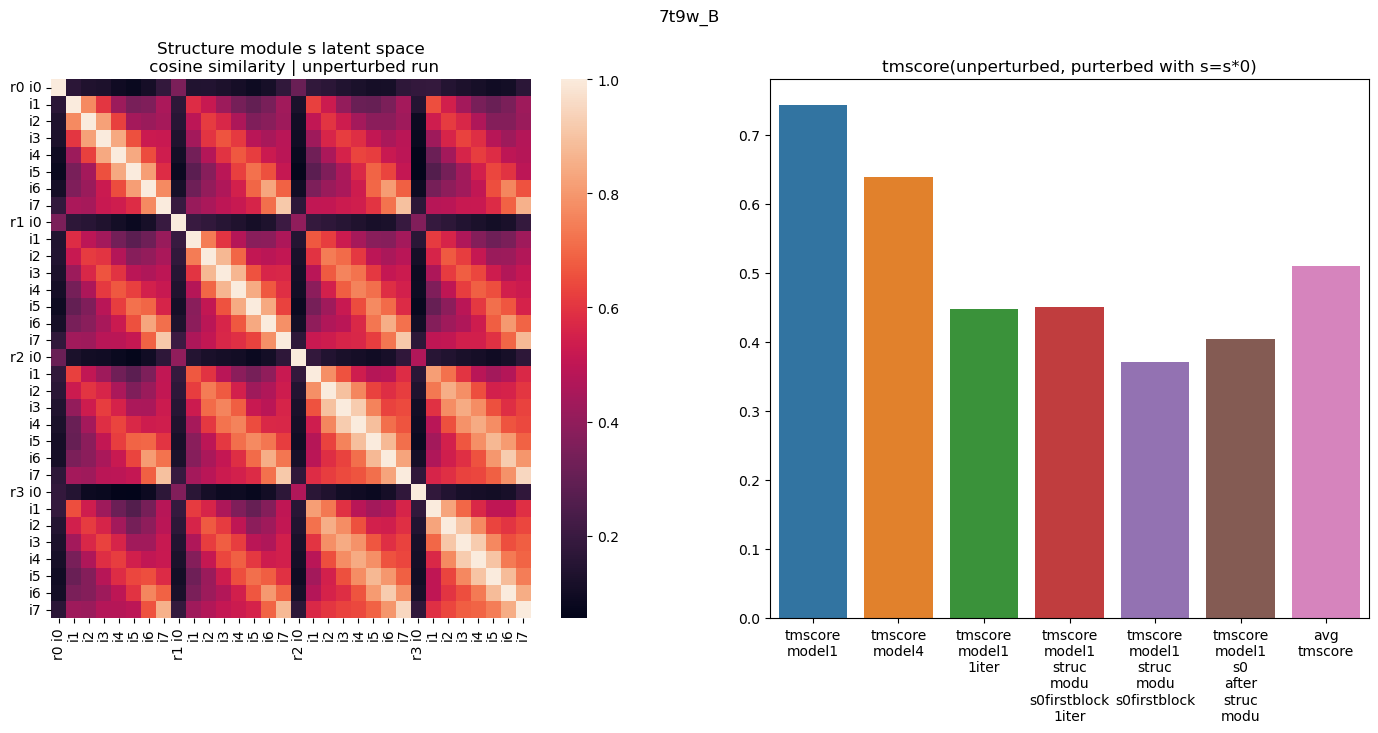

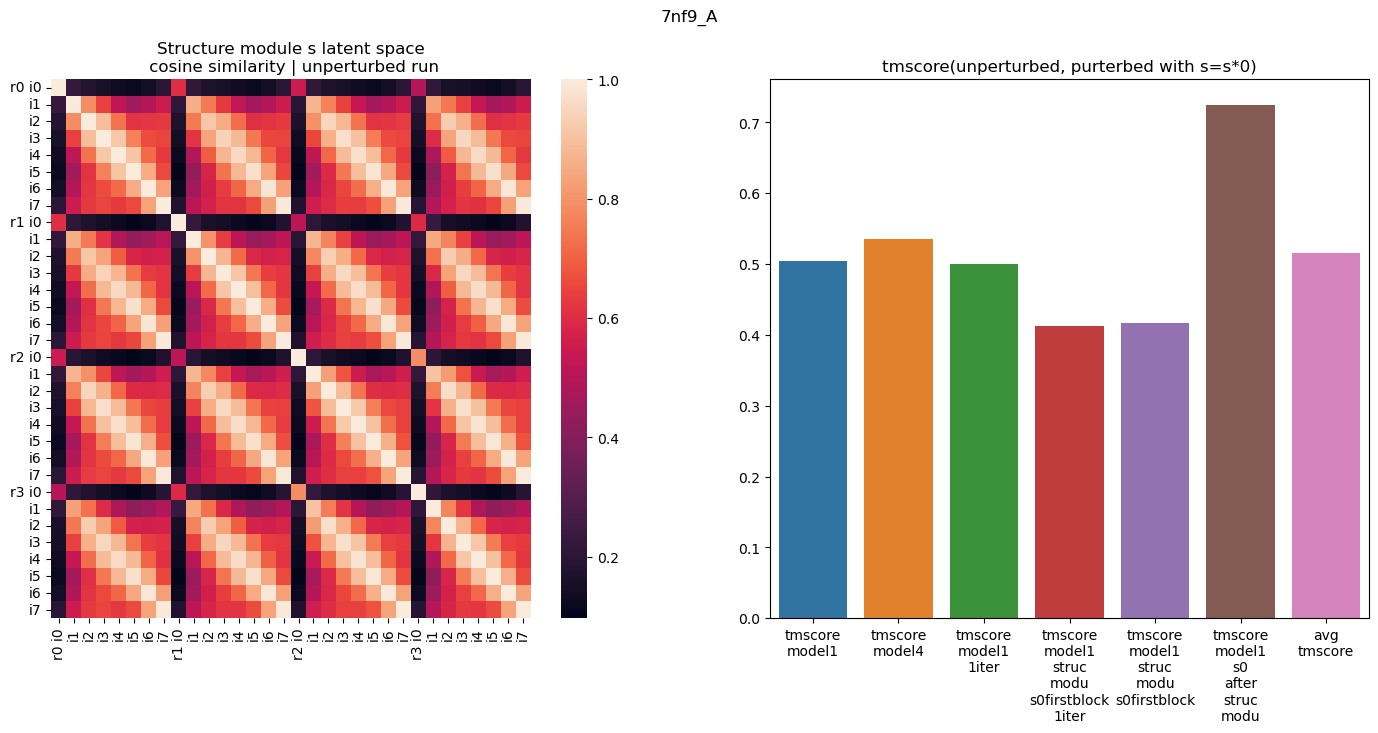

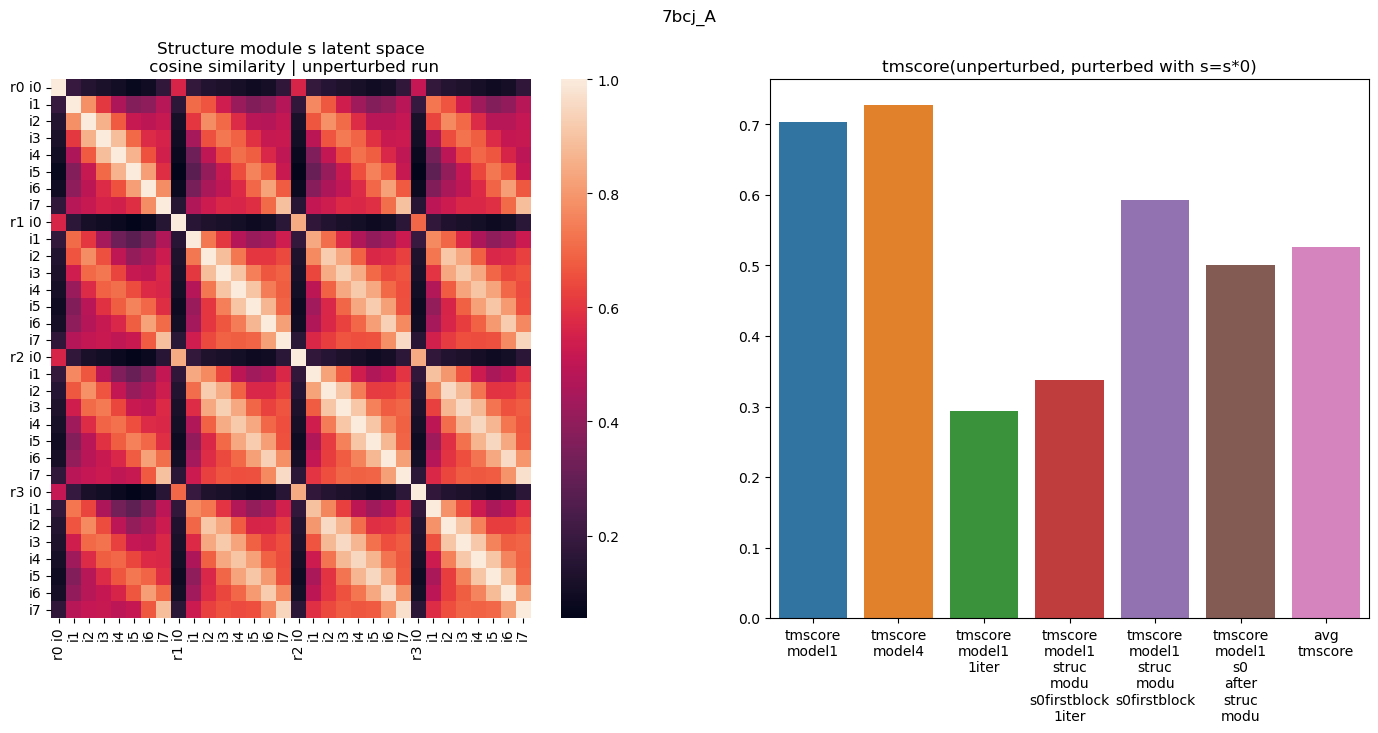

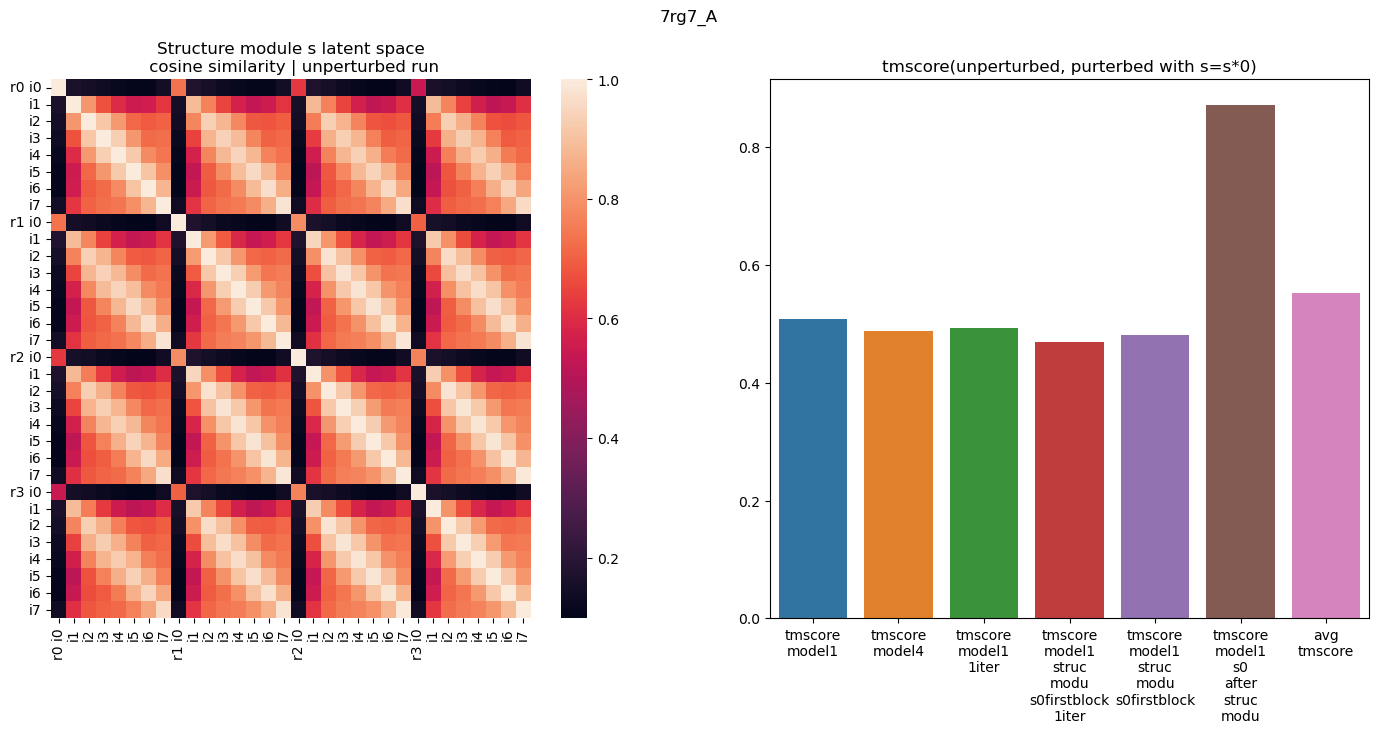

In [63]:
for i, p in enumerate(sorted_portein_list):
    latent_space_cosine_AND_tmscore_barchart(p)
    if i>5: break